In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as torch_d
# import tikzplotlib

In [22]:
## reset defaults
plt.rcdefaults()

## Set up LaTeX fonts
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    })

In [24]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Receiver2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)


class Encoder2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        return self.lin2(y)

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)

    def forward(self, y):
        return self.lin1(y)

class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        alphabet = np.arange(-(M-1),M,2)
        self.lin1 = nn.Linear(M, 1)
        self.lin1.weight = nn.Parameter(torch.Tensor([[i for i in alphabet]])) # set weigths equal to alphabet

    def forward(self, y):
        y = self.lin1(y)
        return y


class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return nn.functional.one_hot(torch.argmax(input, dim=-1), 8).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [25]:
def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [26]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [27]:
M = 8
n = 10_000
nepochs = 4000
lr = 0.001

dec = Receiver2(M)
enc = Encoder2(M)
mapper = Mapper(M)
loss_fn = nn.CrossEntropyLoss()

In [28]:
def sampler(logits, n, M):
    temperature = 10
    estimator = STEFunction.apply
    g_dist = torch_d.Gumbel(loc=torch.tensor([0.]), scale=torch.tensor([1.])) # create Gumbel dist
    g = g_dist.sample(sample_shape=[n, M]).squeeze()
    s_bar = nn.functional.softmax(input=((g + logits) / temperature), dim=1)
    s = estimator(s_bar) # straight through estimator
    return s

def train_encoder_at_dB(dB, report=False):
    SNR_dB = dB
    SNR = 10**(SNR_dB/10)
    sigma2 = 1/SNR

    opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()) + list(mapper.parameters()), lr=lr)


    for j in range(nepochs):
        logits = enc(torch.tensor([1], dtype=torch.float))

        # Sample indexes
        # onehot = sampler(probs, n, M)
        onehot = nn.functional.gumbel_softmax(logits.expand(n, -1), tau=10, hard=True)
        indices = torch.argmax(onehot, dim=1)

        # Modulation
        # with torch.no_grad():
        alphabet_t = mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze()
        probs =  nn.functional.softmax(logits, -1)
        norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
        alphabet_norm =  alphabet_t * norm_factor
        symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

        # Channel
        y = AWGN_channel(symbols, sigma2)

        # Demodulator
        ll = dec(y.reshape(-1,1))
        # app = nn.functional.softmax(ll, 1) #Q(X|Y)

        # Loss
        loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices.detach()))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
        opt.zero_grad()
        loss.backward()

        opt.step()

        # Printout and visualization
        if report and j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

    if False:
        print('probs: ', probs)
        plt.hist(symbols.detach().numpy(), bins=100)
        plt.show()

    return loss

### Compare Results

In [29]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [30]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [31]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [3]:
n = 10_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
mi_gcs = []
for snrdB in SNR_dBs:
    print('SNR: ', snrdB)
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))
    mi_gcs.append(-2*(train_encoder_at_dB(snrdB, report=True)).detach().numpy().tolist()/np.log(2))

In [10]:
mi_pas = [2.003341284436633, 2.292658066954688, 2.554683610537927, 2.848158933553844, 3.154347558086842, 3.4380587380826744, 3.7802969900283276, 4.075253427633475, 4.341019249907679, 4.646519943837226, 4.885983083453772, 5.097619430160718, 5.366562115961658, 5.545744992485489, 5.702222031511809, 5.8247455676741895, 5.899446576041752]

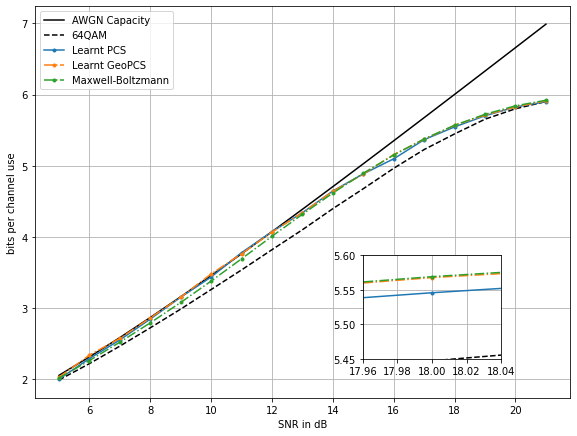

In [23]:
# Plot
plt.rcParams['figure.figsize'] = [8*1.2, 6*1.2]

fig, ax1 = plt.subplots()
ax1.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
ax1.plot(SNR_dBs, mi_64, color='black', ls='--', label = '64QAM')

ax1.plot(SNR_dBs, mi_pas, color='C0', marker='o', markersize=3, label='Learnt PCS')
ax1.plot(SNR_dBs, mi_gcs, color='C1', marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')

ax1.legend(loc='upper left')
ax1.grid()
ax1.set_ylabel('bits per channel use')
ax1.set_xlabel('SNR in dB')

l, b, h, w = 0.6, .2, .2, .2
ax2 = fig.add_axes([l, b, w, h])

# plt.rcParams['figure.figsize'] = [4, 4]
ax2.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
ax2.plot(SNR_dBs, mi_64, color='black', ls='--', label = '64QAM')

ax2.plot(SNR_dBs, mi_pas, color='C0', marker='o', markersize=3, label='Learnt PCS')
ax2.plot(SNR_dBs, mi_gcs, color='C1', marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')

# plt.legend()
ax2.grid()
ax2.set_ylim([5.45,5.6])
ax2.set_xlim([17.96,18.04])
# plt.ylabel('bits per channel use')
# plt.xlabel('SNR in dB')
# tikzplotlib.save("stark_gcs_18dB_exp_tikz.tex")
plt.show()
fig.savefig("embedded.pdf", format="pdf", dpi=600)
